In [1]:
# -*- coding: utf-8 -*-
# PCE(4q,k=2) vs QAOA(q,p=1/2/3) for Max-Cut
# 変更点：
#  - ローカル探索は論文準拠の「単一ビット反転を1周だけ」のみ（SWAP型は削除）
#  - PCEアンサッツ：層ごとに単一軸回転→2Q層（brickwork）
#  - 評価指標：後処理なし／bit-flip(1周) の両方で近似率を表示
#  - 資源カウント：entangler数（MS相当）とCNOT換算（RZZ=2CNOT/edge）を併記

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, product
from typing import List, Tuple
from scipy.optimize import minimize
from random import seed as pyseed
pyseed(0); np.random.seed(0)

# --------------------------
# 問題設定（|V|=18）
# --------------------------
V = 18
p_edge = 1.0  # 1.0で完全グラフ
G = nx.gnp_random_graph(V, p_edge, seed=42)
E = G.number_of_edges()
print(f"Graph: |V|={V}, |E|={E}")

def cut_size(G, S):
    return sum(1 for (u,v) in G.edges() if ((u in S) ^ (v in S)))

def draw_graph_with_partition(G, S=None, title="Max-Cut graph (current partition)"):
    pos = nx.spring_layout(G, seed=123)
    if S is None:
        node_color = "lightgray"; edge_colors = "lightgray"; edge_widths=1.5
    else:
        node_color = ["tab:blue" if i in S else "tab:orange" for i in G.nodes()]
        Sbar = set(G.nodes()) - set(S)
        def is_cut(u, v): return (u in S and v in Sbar) or (u in Sbar and v in S)
        edge_colors = ["crimson" if is_cut(u, v) else "lightgray" for (u, v) in G.edges()]
        edge_widths = [2.5 if (edge_colors[i] == "crimson") else 1.2 for i in range(len(edge_colors))]
    plt.figure(figsize=(6.0, 5.2), dpi=120)
    nx.draw_networkx(G, pos=pos, node_color=node_color,
                     with_labels=True, font_size=9, node_size=550,
                     edge_color=edge_colors, width=edge_widths)
    from matplotlib.patches import Patch
    if S is not None:
        legend_elems = [
            Patch(facecolor="tab:blue", edgecolor="none", label="Side A"),
            Patch(facecolor="tab:orange", edgecolor="none", label="Side B"),
            Patch(facecolor="crimson", edgecolor="none", label="Cut edges"),
            Patch(facecolor="lightgray", edgecolor="none", label="Non-cut edges"),
        ]
        plt.legend(handles=legend_elems, loc="lower left", fontsize=8, frameon=False)
    plt.title(title); plt.tight_layout(); plt.show()



# --------------------------
# PCE (n=4, k=2) 論文寄せ
# --------------------------
from qulacs import QuantumState
from qulacs.gate import RX, RY, RZ, CNOT
try:
    from qulacs import Observable
    OBS_FALLBACK = None
except ImportError:
    from qulacs.observable import create_observable_from_pauli_string as OBS_FALLBACK
    Observable = None

# === PCEハイパラ・設計 ===
n_qubits = 4
k = 2
reps = 2                 # brickwork層数
use_ring = True          # 2Q層はリング
alpha = n_qubits         # tanhの急峻さ
beta = 0.5               # 正則化強度
optimizer = "Nelder-Mead"
maxiter = 1500

# 層ごとに1軸だけ回す（例: Y, Z, Xをローテーション）
PCE_AXES_PER_LAYER = ["Y", "Z", "X"]
# 2Q層にパラメータ（RZZ角 γ）を1つ/層持たせる：True→RZZ(γ)を全辺、False→CNOT一巡
PCE_USE_PARAM_ZZ = True

def ring_edges(n: int, ring: bool=True):
    es = [(q, q+1) for q in range(n-1)]
    if ring and n >= 2: es += [(n-1, 0)]
    return es

# 収容力: m <= 3*C(n,2) （k=2）
cap_per_axis = n_qubits*(n_qubits-1)//2
cap_total = 3*cap_per_axis
if V > cap_total:
    raise ValueError(f"|V|={V} は収容力 {cap_total} を超えます。n を上げるか設計を見直してください。")

# 疑似ノードの軸割当
size_x = min(V//3, cap_per_axis)
size_y = min(V//3, cap_per_axis)
size_z = V - size_x - size_y
node_x = list(range(0, size_x))
node_y = list(range(size_x, size_x+size_y))
node_z = list(range(size_x+size_y, V))

def build_pairs(n:int, count:int)->List[Tuple[int,int]]:
    pairs=[]
    for idx,(i,j) in enumerate(combinations(range(n),2)):
        if idx>=count: break
        pairs.append((i,j))
    return pairs

px_pairs = build_pairs(n_qubits, len(node_x))
py_pairs = build_pairs(n_qubits, len(node_y))
pz_pairs = build_pairs(n_qubits, len(node_z))

def make_two_pauli_obs(pauli:str, i:int, j:int):
    term = f"{pauli} {i} {pauli} {j}"
    if Observable is not None:
        obs = Observable(n_qubits); obs.add_operator(1.0, term); return obs
    else:
        return OBS_FALLBACK(f"1.0 {term}")

px_obs = [make_two_pauli_obs("X", i, j) for (i,j) in px_pairs]
py_obs = [make_two_pauli_obs("Y", i, j) for (i,j) in py_pairs]
pz_obs = [make_two_pauli_obs("Z", i, j) for (i,j) in pz_pairs]

# --- PCEアンサッツ (層ごとに単一軸回転 + 2Q層) ---
def pce_num_params(n_qubits:int, reps:int, use_param_zz:bool)->int:
    per_layer = n_qubits + (1 if use_param_zz else 0)  # 1Q×n + [RZZ角1]
    return reps * per_layer

def build_state_pce(theta: np.ndarray) -> QuantumState:
    st = QuantumState(n_qubits); st.set_zero_state()
    t = 0
    edges = ring_edges(n_qubits, ring=use_ring)
    for layer in range(reps):
        ax = PCE_AXES_PER_LAYER[layer % len(PCE_AXES_PER_LAYER)]
        # 単一軸回転（各qubit 1パラメータ）
        for q in range(n_qubits):
            ang = theta[t]; t += 1
            if   ax == "X": RX(q, ang).update_quantum_state(st)
            elif ax == "Y": RY(q, ang).update_quantum_state(st)
            else:           RZ(q, ang).update_quantum_state(st)
        # 2Q層
        if PCE_USE_PARAM_ZZ:
            gamma = theta[t]; t += 1
            # e^{-i gamma Z⊗Z} = CNOT - RZ(2γ) - CNOT
            for (u,v) in edges:
                CNOT(u,v).update_quantum_state(st)
                RZ(v, 2*gamma).update_quantum_state(st)
                CNOT(u,v).update_quantum_state(st)
        else:
            for (u,v) in edges:
                CNOT(u, v).update_quantum_state(st)
    return st

n_params = pce_num_params(n_qubits, reps, PCE_USE_PARAM_ZZ)

def node_scores(theta: np.ndarray):
    st = build_state_pce(theta)
    exp={}; idx=0
    for obs in px_obs: exp[idx]=obs.get_expectation_value(st); idx+=1
    for obs in py_obs: exp[idx]=obs.get_expectation_value(st); idx+=1
    for obs in pz_obs: exp[idx]=obs.get_expectation_value(st); idx+=1
    return exp

# Edwards–Erdős下界（スケール）
edwards_erdos = E/2 + (V-1)/4

# 損失 & カウンタ
hist_loss=[]; pce_eval_count=0
def loss(theta: np.ndarray)->float:
    global pce_eval_count
    m = node_scores(theta)
    s=0.0
    for (u,v) in G.edges():
        s += np.tanh(alpha*m[u]) * np.tanh(alpha*m[v])
    mean_sq = np.mean([np.tanh(alpha*m[i])**2 for i in range(V)])
    reg = beta * edwards_erdos * (mean_sq**2)
    val = float(s + reg)
    hist_loss.append(val)
    pce_eval_count += 1
    return val

# --- 最適化 ---
x0 = np.random.uniform(0, 2*np.pi, size=n_params)
res = minimize(loss, x0, method=optimizer, options={"maxiter": maxiter})
final_theta = res.x
final_m = node_scores(final_theta)

# --- 後処理（論文準拠: 単一ビット反転を1周だけ） ---
def one_round_bit_flip(G, bits_pm1: np.ndarray):
    cur = bits_pm1.copy()
    def bits_to_S(bb): return {i for i,b in enumerate(bb) if b>0}
    best_cut = cut_size(G, bits_to_S(cur))
    for i in range(G.number_of_nodes()):
        cur[i] *= -1  # 1ビット反転
        c2 = cut_size(G, bits_to_S(cur))
        if c2 >= best_cut:
            best_cut = c2      # 改善(同等以上)なら採用
        else:
            cur[i] *= -1       # 悪化なら戻す
    return cur, best_cut

# --- PCE: 二値化 → 「後処理なし / bit-flip(1周)」
S_pce_raw = {i for i in range(V) if final_m[i] >= 0.0}
cut_pce_raw = cut_size(G, S_pce_raw)
bits_raw = np.array([1 if i in S_pce_raw else -1 for i in range(V)])
bits_pce_flip1, cut_pce_flip1 = one_round_bit_flip(G, bits_raw)
S_pce_flip1 = {i for i,b in enumerate(bits_pce_flip1) if b>0}

# --- PCEの2Q資源カウント（1評価あたり → 総計） ---
def pce_per_eval_twoq(n:int, reps:int, ring:bool, use_param_zz:bool):
    edges_per_layer = n if ring else (n-1)
    entangler_per_layer = edges_per_layer
    if use_param_zz:
        cnot_eq_per_layer = 2 * edges_per_layer  # RZZ=2CNOT/edge
    else:
        cnot_eq_per_layer = edges_per_layer      # CNOT/edge
    return (reps*entangler_per_layer, reps*cnot_eq_per_layer)

pce_ent_per_eval, pce_cnot_per_eval = pce_per_eval_twoq(n_qubits, reps, use_ring, PCE_USE_PARAM_ZZ)
pce_total_entanglers = pce_ent_per_eval * pce_eval_count
pce_total_2Q_cnot_eq = pce_cnot_per_eval * pce_eval_count

print(f"[PCE 4q,k=2] cut(no post)={cut_pce_raw}, cut(bit-flip 1round)={cut_pce_flip1}, "
      f"evals={pce_eval_count}, entanglers≈{pce_total_entanglers}, 2Q(CNOT-eq)≈{pce_total_2Q_cnot_eq}")



# --------------------------
# QAOA (n=18, p=1/2/3) — 厳密期待値最適化 + サンプリング
# --------------------------
from qulacs import Observable as QObs

def run_qaoa_exact(Gq, p:int, maxiter=300, n_starts=5, samples=10000, seed=0):
    from qulacs import QuantumState
    from qulacs.gate import RX, RZ, CNOT
    rng = np.random.default_rng(seed)
    Vq = Gq.number_of_nodes()
    edges = list(Gq.edges())

    # Max-Cut期待値: sum_{(u,v)} (1 - Z_u Z_v)/2 = const - 0.5<ΣZ_uZ_v>
    obs = QObs(Vq); const = 0.0
    for (u,v) in edges:
        obs.add_operator(-0.5, f"Z {u} Z {v}")
        const += 0.5

    eval_counter = {"n":0}

    def build_state(betas, gammas):
        st = QuantumState(Vq); st.set_zero_state()
        # |+>^n
        for q in range(Vq): RX(q, np.pi/2).update_quantum_state(st)
        for layer in range(p):
            gamma, beta = gammas[layer], betas[layer]
            # ZZコスト: CNOT-RZ(2γ)-CNOT
            for (u,v) in edges:
                CNOT(u, v).update_quantum_state(st)
                RZ(v, 2*gamma).update_quantum_state(st)
                CNOT(u, v).update_quantum_state(st)
            # Mixer
            for q in range(Vq): RX(q, 2*beta).update_quantum_state(st)
        return st

    def objective(x):
        eval_counter["n"] += 1
        betas, gammas = x[:p], x[p:]
        st = build_state(betas, gammas)
        return -(const + obs.get_expectation_value(st))  # maximize→minimize

    best = (1e9, None)
    for t in range(n_starts):
        x0 = rng.uniform(0, np.pi, size=2*p)
        res = minimize(objective, x0, method="Powell",
                       options={"maxiter": maxiter, "xtol":1e-3, "ftol":1e-3})
        val = objective(res.x)
        if val < best[0]:
            best = (val, res.x)

    betas, gammas = best[1][:p], best[1][p:]
    st = build_state(betas, gammas)

    # サンプリング → best（後処理なし）
    best_cut_raw = -1; best_bits_raw = None
    for _ in range(samples):
        s = st.sampling(1)[0]
        z = np.array([1 - 2*((s>>q)&1) for q in range(Vq)])  # ±1
        S = {i for i,val in enumerate(z) if val>0}
        c = cut_size(Gq, S)
        if c > best_cut_raw:
            best_cut_raw = c
            best_bits_raw = np.array([1 if i in S else -1 for i in range(Vq)])

    # 論文準拠: bit-flip(1周)
    best_bits_flip1, best_cut_flip1 = one_round_bit_flip(Gq, best_bits_raw)

    # 資源（評価回数に対する）: entangler と CNOT換算
    per_eval_ent = p * len(edges)            # 1 entangler/edge/層
    per_eval_cnot = 2 * len(edges) * p       # RZZ=2CNOT/edge/層
    total_ent = per_eval_ent * eval_counter["n"]
    total_cnot = per_eval_cnot * eval_counter["n"]

    return {
        "p": p,
        "best_cut_raw": best_cut_raw,
        "best_cut_flip1": best_cut_flip1,
        "bits_raw": best_bits_raw,
        "bits_flip1": best_bits_flip1,
        "evals": eval_counter["n"],
        "approx_total_entanglers": total_ent,
        "approx_total_2Q_cnot_eq": total_cnot
    }

# 実行
results = []
for p in [1,2,3]:
    r = run_qaoa_exact(G, p=p, maxiter=300, n_starts=5, samples=10000, seed=1234)
    results.append(r)
    print(f"[QAOA n=18, p={p}] cut(no post)={r['best_cut_raw']}, "
          f"cut(bit-flip 1round)={r['best_cut_flip1']}, "
          f"evals={r['evals']}, entanglers≈{r['approx_total_entanglers']}, "
          f"2Q(CNOT-eq)≈{r['approx_total_2Q_cnot_eq']}")

# ベストQAOA（bit-flip後）を可視化
best_r = max(results, key=lambda d: d["best_cut_flip1"])
S_qaoa = {i for i,b in enumerate(best_r["bits_flip1"]) if b>0}


# --------------------------
# 厳密最適 & 近似率（後処理なし/あり）
# --------------------------
def maxcut_opt_exact(G):
    Vloc = G.number_of_nodes()
    best_cut, best_S = -1, None
    for bits in product([0,1], repeat=Vloc):
        S = {i for i,b in enumerate(bits) if b==1}
        c = cut_size(G, S)
        if c > best_cut:
            best_cut, best_S = c, S
    return best_cut, best_S

opt_cut, _ = maxcut_opt_exact(G)
rand_ratio = (E/2) / opt_cut  # ランダム基準

print(f"\n[Optimal] cut={opt_cut}  | Random baseline ratio ≈ {rand_ratio:.3f}")

# PCE 近似率
pce_ratio_raw   = cut_pce_raw   / opt_cut
pce_ratio_flip1 = cut_pce_flip1 / opt_cut
print(f"PCE ratio (no post)   = {pce_ratio_raw:.4f}  (cut={cut_pce_raw})")
print(f"PCE ratio (bit-flip1) = {pce_ratio_flip1:.4f}  (cut={cut_pce_flip1})")

# QAOA 近似率
for r in results:
    print(f"QAOA p={r['p']} ratio (no post)   = {r['best_cut_raw']/opt_cut:.4f}  (cut={r['best_cut_raw']})")
    print(f"QAOA p={r['p']} ratio (bit-flip1) = {r['best_cut_flip1']/opt_cut:.4f}  (cut={r['best_cut_flip1']})")

# r >= 16/17 達成可否（論文で用いられる目安）
r_threshold = 16/17
print(f"\n[Threshold check] r >= 16/17 ≈ {r_threshold:.4f}")
print("PCE:", "OK" if pce_ratio_raw >= r_threshold else "NG", "(no post)  |",
              "OK" if pce_ratio_flip1 >= r_threshold else "NG", "(bit-flip1)")
for r in results:
    ok_raw   = "OK" if (r["best_cut_raw"]/opt_cut)   >= r_threshold else "NG"
    ok_flip1 = "OK" if (r["best_cut_flip1"]/opt_cut)>= r_threshold else "NG"
    print(f"QAOA p={r['p']}: {ok_raw} (no post) | {ok_flip1} (bit-flip1)")

# --------------------------
# まとめ（論文寄りの要素を併記）
# --------------------------
print("\n=== Summary (V=18) ===")
print(f"[PCE] evals={pce_eval_count}, entanglers≈{pce_total_entanglers}, 2Q(CNOT-eq)≈{pce_total_2Q_cnot_eq}")
print(f"      cut(no post)={cut_pce_raw}, ratio={pce_ratio_raw:.4f} | cut(bit-flip1)={cut_pce_flip1}, ratio={pce_ratio_flip1:.4f}")
for r in results:
    print(f"[QAOA p={r['p']}] evals={r['evals']}, entanglers≈{r['approx_total_entanglers']}, 2Q(CNOT-eq)≈{r['approx_total_2Q_cnot_eq']}")
    print(f"      cut(no post)={r['best_cut_raw']}, ratio={r['best_cut_raw']/opt_cut:.4f} | cut(bit-flip1)={r['best_cut_flip1']}, ratio={r['best_cut_flip1']/opt_cut:.4f}")




Graph: |V|=18, |E|=153
[PCE 4q,k=2] cut(no post)=77, cut(bit-flip 1round)=81, evals=2089, entanglers≈16712, 2Q(CNOT-eq)≈33424
[QAOA n=18, p=1] cut(no post)=81, cut(bit-flip 1round)=81, evals=244, entanglers≈37332, 2Q(CNOT-eq)≈74664
[QAOA n=18, p=2] cut(no post)=81, cut(bit-flip 1round)=81, evals=981, entanglers≈300186, 2Q(CNOT-eq)≈600372
[QAOA n=18, p=3] cut(no post)=81, cut(bit-flip 1round)=81, evals=1868, entanglers≈857412, 2Q(CNOT-eq)≈1714824

[Optimal] cut=81  | Random baseline ratio ≈ 0.944
PCE ratio (no post)   = 0.9506  (cut=77)
PCE ratio (bit-flip1) = 1.0000  (cut=81)
QAOA p=1 ratio (no post)   = 1.0000  (cut=81)
QAOA p=1 ratio (bit-flip1) = 1.0000  (cut=81)
QAOA p=2 ratio (no post)   = 1.0000  (cut=81)
QAOA p=2 ratio (bit-flip1) = 1.0000  (cut=81)
QAOA p=3 ratio (no post)   = 1.0000  (cut=81)
QAOA p=3 ratio (bit-flip1) = 1.0000  (cut=81)

[Threshold check] r >= 16/17 ≈ 0.9412
PCE: OK (no post)  | OK (bit-flip1)
QAOA p=1: OK (no post) | OK (bit-flip1)
QAOA p=2: OK (no post) | O

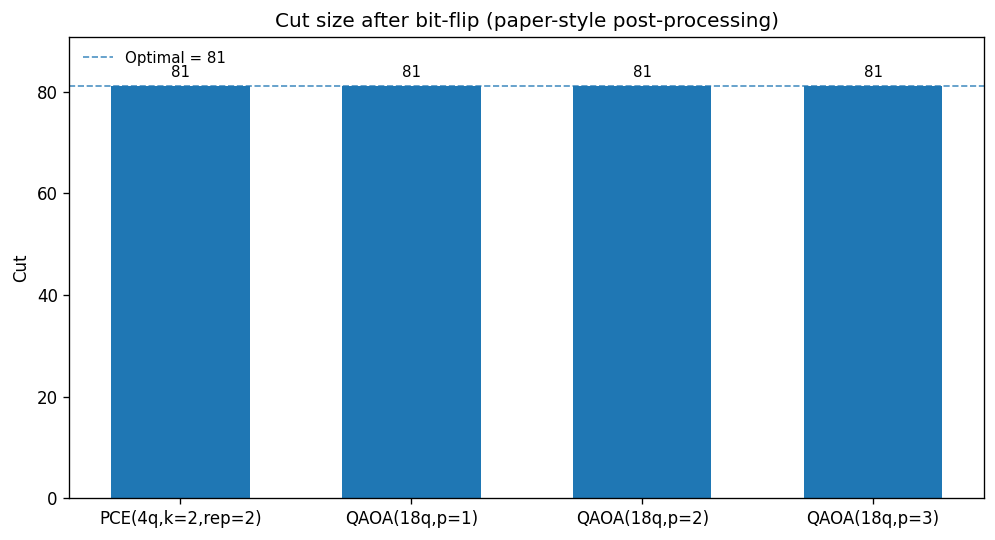

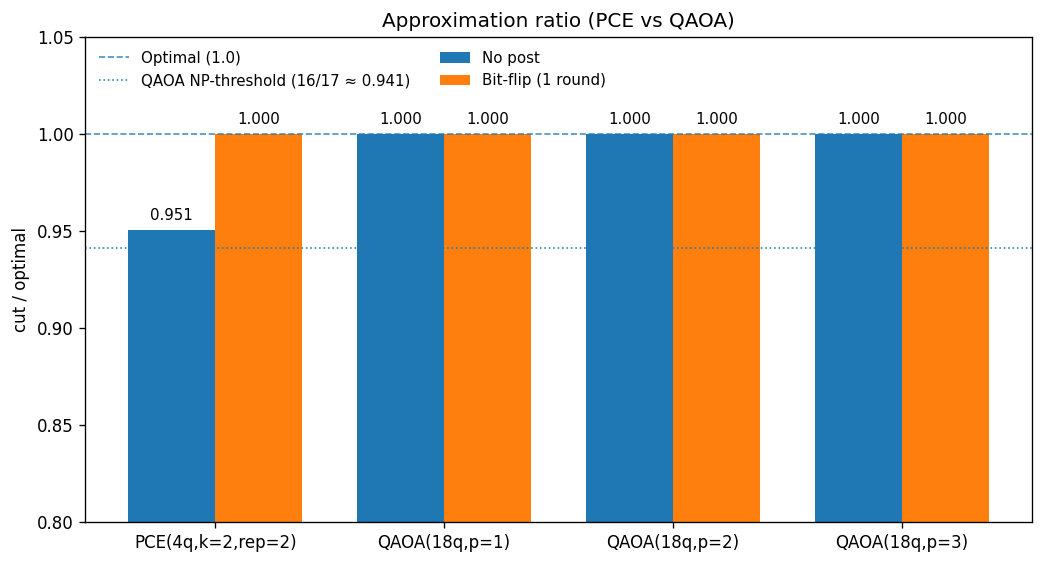

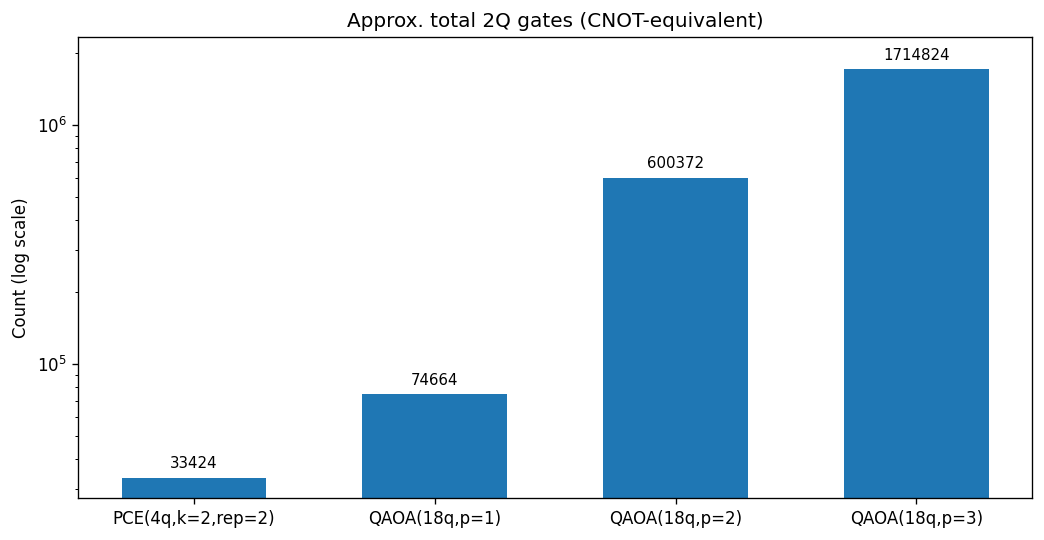

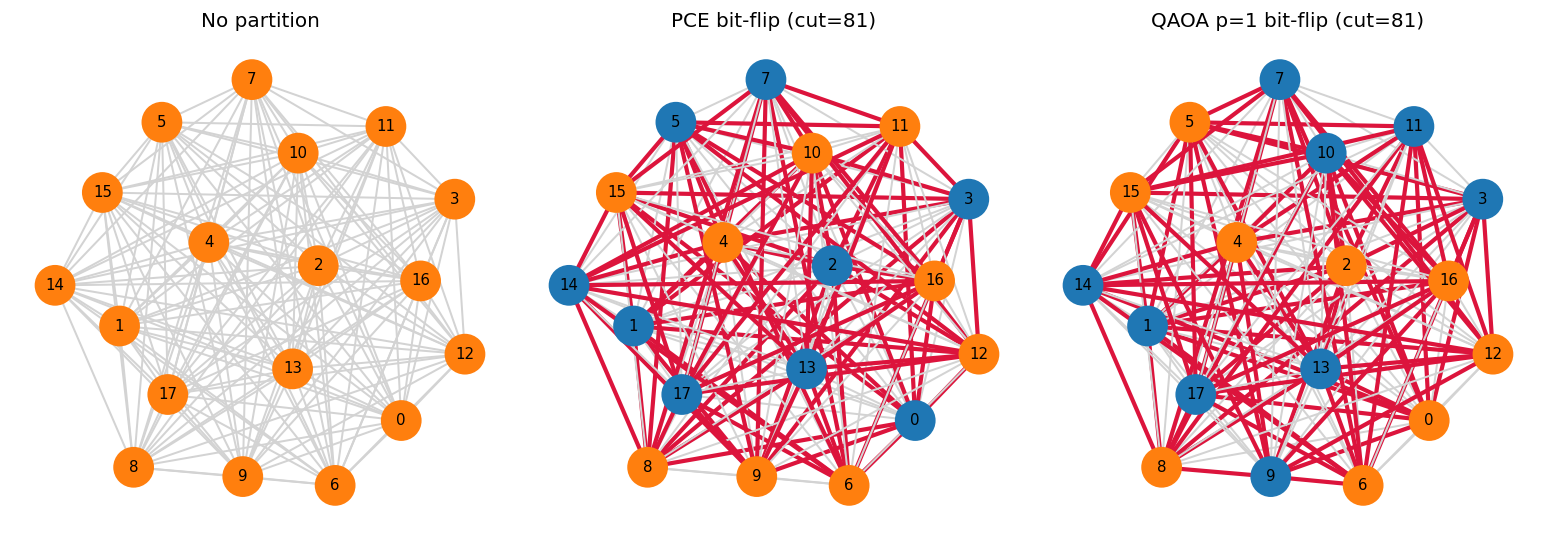

In [2]:
# === 可視化ユーティリティ（バー上に数値） ===
def add_bar_labels(ax, bars, fmt="{:.3f}", dy_pt=4):
    for b in bars:
        h = b.get_height()
        ax.annotate(fmt.format(h),
                    xy=(b.get_x()+b.get_width()/2, h),
                    xytext=(0, dy_pt), textcoords="offset points",
                    ha="center", va="bottom", fontsize=9, clip_on=False)

# === 比較用データ整形 ===
# 例: 変数を明示しておく（既にあれば不要）
k_pce = 2
rep_pce = 2

# --- 比較用データ整形（先頭のPCE表記を 4q,k=2,rep=2 に） ---
labels = [f"PCE(4q,k={k_pce},rep={rep_pce})"] + [f"QAOA({G.number_of_nodes()}q,p={r['p']})" for r in results]

cuts_raw   = [cut_pce_raw]   + [r["best_cut_raw"]   for r in results]
cuts_flip1 = [cut_pce_flip1] + [r["best_cut_flip1"] for r in results]

ratios_raw   = [c/opt_cut for c in cuts_raw]
ratios_flip1 = [c/opt_cut for c in cuts_flip1]

twoq_cnot = [pce_total_2Q_cnot_eq] + [r["approx_total_2Q_cnot_eq"] for r in results]
entanglers = [pce_total_entanglers] + [r["approx_total_entanglers"] for r in results]

x = np.arange(len(labels))

# === 図1: カット値（bit-flip 1周 後）棒グラフ ===
fig1, ax1 = plt.subplots(figsize=(8.4, 4.6), dpi=120)
bars1 = ax1.bar(x, cuts_flip1, width=0.6)
ax1.axhline(opt_cut, linewidth=1, linestyle="--", alpha=0.8, label=f"Optimal = {opt_cut}")
ax1.set_title("Cut size after bit-flip (paper-style post-processing)")
ax1.set_ylabel("Cut")
ax1.set_xticks(x, labels) 
ax1.set_ylim(0, max(cuts_flip1)*1.12)
add_bar_labels(ax1, bars1, fmt="{:.0f}", dy_pt=4)
ax1.legend(loc="upper left", fontsize=9, frameon=False)
plt.tight_layout(); plt.show()

# === 図2: 近似率（raw vs bit-flip）グループ棒 ===
w = 0.38
fig2, ax2 = plt.subplots(figsize=(8.8, 4.8), dpi=120)
bars2a = ax2.bar(x - w/2, ratios_raw,   width=w, label="No post")
bars2b = ax2.bar(x + w/2, ratios_flip1, width=w, label="Bit-flip (1 round)")
ax2.axhline(1.0, linewidth=1, linestyle="--", alpha=0.8, label="Optimal (1.0)")
ax2.axhline(16/17, linewidth=1, linestyle=":", alpha=0.9,
            label="QAOA NP-threshold (16/17 ≈ 0.941)")


ax2.set_title("Approximation ratio (PCE vs QAOA)")
ax2.set_ylabel("cut / optimal")
ax2.set_xticks(x, labels)
ax2.set_ylim(0.8, 1.05)
add_bar_labels(ax2, bars2a, fmt="{:.3f}", dy_pt=4)
add_bar_labels(ax2, bars2b, fmt="{:.3f}", dy_pt=4)
ax2.legend(loc="upper left", fontsize=9, frameon=False, ncol=2)
plt.tight_layout(); plt.show()

# === 図3: 量子資源（2Q: CNOT換算）棒グラフ（対数軸） ===
fig3, ax3 = plt.subplots(figsize=(8.8, 4.6), dpi=120)
bars3 = ax3.bar(x, twoq_cnot, width=0.6)
ax3.set_title("Approx. total 2Q gates (CNOT-equivalent)")
ax3.set_ylabel("Count (log scale)")
ax3.set_xticks(x, labels)
ax3.set_yscale("log")
lo, hi = ax3.get_ylim()
ax3.set_ylim(lo, hi*1.12)
add_bar_labels(ax3, bars3, fmt="{:.0f}", dy_pt=4)
plt.tight_layout(); plt.show()

# === （任意）図4: グラフ分割の“見た目”を並べて比較（3枚パネル） ===
def draw_partition_panel(G, S_list, titles):
    pos = nx.spring_layout(G, seed=123)  # 3枚で同じレイアウトに固定
    fig, axes = plt.subplots(1, len(S_list), figsize=(13, 4.6), dpi=120)
    if len(S_list) == 1: axes = [axes]
    for ax, S, ttl in zip(axes, S_list, titles):
        node_color = ["tab:blue" if i in S else "tab:orange" for i in G.nodes()]
        Sbar = set(G.nodes()) - set(S)
        def is_cut(u, v): return (u in S and v in Sbar) or (u in Sbar and v in S)
        edge_colors = ["crimson" if is_cut(u, v) else "lightgray" for (u, v) in G.edges()]
        edge_widths = [2.5 if (edge_colors[i] == "crimson") else 1.2 for i in range(len(edge_colors))]
        nx.draw_networkx(G, pos=pos, node_color=node_color, with_labels=True, font_size=9,
                         node_size=550, edge_color=edge_colors, width=edge_widths, ax=ax)
        ax.set_title(ttl); ax.axis("off")
    plt.tight_layout(); plt.show()

# “無分割 / PCE-bitflip / QAOA(best)-bitflip” を横並びで
S_none = None
S_pce  = S_pce_flip1
S_qaoa = {i for i,b in enumerate(best_r["bits_flip1"]) if b>0}
draw_partition_panel(G, [set(), S_pce, S_qaoa],
                     ["No partition", f"PCE bit-flip (cut={cut_pce_flip1})",
                      f"QAOA p={best_r['p']} bit-flip (cut={best_r['best_cut_flip1']})"])
